In [1]:
import pandas as pd
import numpy as np
import gc
import os
import datetime
import json

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [3]:
import matplotlib.pyplot as plt

## Settings

In [4]:
with open('settings.json', 'r') as j:
    json_data = json.load(j)

In [5]:
project_path = json_data["project_path"]

data_path = os.path.join(project_path, "data")
python_path = os.path.join(project_path, "python")


data_chunks = os.path.join(data_path,"data_chunks")
output_data_path = os.path.join(data_path, "output")
supporting_dp = os.path.join(data_path, "supporting")

role = json_data["role"]

In [6]:
pivoted_dt = pd.read_csv(os.path.join(output_data_path, "input_dataset_pivoted.csv")
                         , header=0
                         , parse_dates=['Time'])

In [7]:
pivoted_dt.set_index("Time", drop=True, inplace=True)
pivoted_dt.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,33.0,68.0,23.0,39.0,156.0,261.0,287.0,354.0,371.0,128.0,...,12.0,0.0,4.0,20.0,20.0,11.0,1.0,47.0,1.0,19.0
2011-01-01 01:00:00,42.0,68.0,31.0,59.0,182.0,256.0,245.0,264.0,252.0,116.0,...,10.0,0.0,4.0,22.0,13.0,10.0,5.0,34.0,4.0,18.0
2011-01-01 02:00:00,40.0,59.0,18.0,62.0,170.0,225.0,228.0,255.0,235.0,99.0,...,14.0,0.0,4.0,1.0,1.0,0.0,2.0,11.0,2.0,0.0
2011-01-01 03:00:00,35.0,52.0,18.0,47.0,129.0,216.0,208.0,213.0,183.0,85.0,...,7.0,0.0,4.0,2.0,1.0,0.0,0.0,12.0,0.0,0.0
2011-01-01 04:00:00,17.0,29.0,9.0,31.0,83.0,149.0,185.0,173.0,142.0,63.0,...,13.0,0.0,3.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0


In [8]:
pivoted_dt_train = pivoted_dt.iloc[pivoted_dt.index <pd.Timestamp("2016-05-01 00:00:00")]

In [9]:
m = pivoted_dt_train.values.mean()
s = pivoted_dt_train.values.std()

In [10]:
d_scaled = (pivoted_dt_train - m)/s
d_scaled.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,-0.489076,-0.370739,-0.522886,-0.468789,-0.073209,0.281800,0.369707,0.596236,0.653713,-0.167878,...,-0.560077,-0.60065,-0.587126,-0.533029,-0.533029,-0.563458,-0.597269,-0.441741,-0.597269,-0.536410
2011-01-01 01:00:00,-0.458646,-0.370739,-0.495838,-0.401169,0.014698,0.264895,0.227703,0.291943,0.251371,-0.208450,...,-0.566839,-0.60065,-0.587126,-0.526267,-0.556696,-0.566839,-0.583745,-0.485695,-0.587126,-0.539791
2011-01-01 02:00:00,-0.465408,-0.401169,-0.539791,-0.391026,-0.025874,0.160083,0.170226,0.261514,0.193893,-0.265927,...,-0.553315,-0.60065,-0.587126,-0.597269,-0.597269,-0.600650,-0.593888,-0.563458,-0.593888,-0.600650
2011-01-01 03:00:00,-0.482314,-0.424836,-0.539791,-0.441741,-0.164496,0.129653,0.102605,0.119510,0.018079,-0.313262,...,-0.576983,-0.60065,-0.587126,-0.593888,-0.597269,-0.600650,-0.600650,-0.560077,-0.600650,-0.600650
2011-01-01 04:00:00,-0.543172,-0.502600,-0.570220,-0.495838,-0.320024,-0.096876,0.024841,-0.015731,-0.120543,-0.387645,...,-0.556696,-0.60065,-0.590507,-0.597269,-0.593888,-0.600650,-0.600650,-0.587126,-0.597269,-0.600650


In [11]:
d_scaled_m = d_scaled.values.transpose()

In [12]:
silh_dt = pd.DataFrame()
for r in range(10):
    print(r)
    silh = []
    for i in range(3,16):
        #print(i)
        clustering = KMeans(init='k-means++', n_clusters=i, n_init=1)
        clustering.fit(d_scaled_m)
        silh.append(metrics.silhouette_score(d_scaled_m,clustering.labels_))
        #print(pd.pivot_table(pd.DataFrame({'labels':clustering.labels_
        #                         ,'tmp': range(len(clustering.labels_))})
        #                , values='tmp', index='labels',columns=None, aggfunc=len).values.transpose())
    silh_dt[str(r)]=silh

0
1
2
3
4
5
6
7
8
9


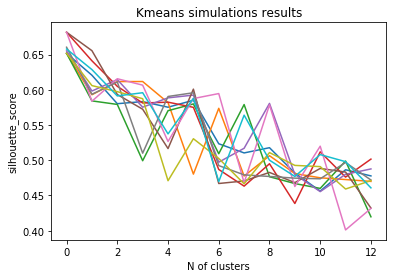

In [13]:
plt.plot(silh_dt)
plt.xlabel("N of clusters")
plt.ylabel("silhouette_score")
plt.title("Kmeans simulations results")
plt.show()

In [14]:
k_optimal = 7
clustering = KMeans(init='k-means++', n_clusters=k_optimal, n_init=1)
clustering.fit(d_scaled_m)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
clustering.labels_

array([1, 1, 1, 1, 5, 5, 2, 2, 2, 4, 1, 6, 6, 6, 6, 6, 2, 2, 0, 3, 3, 0,
       1, 6, 6, 6, 6, 6, 6, 1, 2, 2, 3, 3, 3, 3, 0, 4, 6, 6, 6, 6, 6, 5,
       3, 3, 5, 1, 5, 5, 1, 6, 6, 1, 0, 0, 0, 1, 1, 1, 1, 6, 6, 6, 6, 6,
       6, 5, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 4, 4, 1, 6, 1, 6, 6])

In [16]:
dists = np.zeros(d_scaled_m.shape)
for i in range(d_scaled_m.shape[0]):
    dists[i,] = clustering.cluster_centers_[clustering.labels_[i]]
    
dists = dists - d_scaled_m
dists = dists * dists

cluster_smr = pd.DataFrame({ 'euc_dist':dists.sum(axis = 1)
                             ,'labels' :clustering.labels_
                             ,'square_id':pivoted_dt_train.columns})

cluster_smr.to_csv(os.path.join(supporting_dp, 'clusters.csv'), index=False, header=True) 

In [17]:
cluster_smr.head()

,euc_dist,labels,square_id
0,714.069342,1,1075
1,2540.654637,1,1076
2,750.950385,1,1077
3,434.397957,1,1125
4,2633.580787,5,1126


In [18]:
for i in range(7):
    print(i)
    l = cluster_smr.loc[cluster_smr.labels == i].euc_dist
    print(l.describe())

0
count        7.000000
mean     10648.802746
std       5157.519597
min       5502.466988
25%       5783.418144
50%      11467.976407
75%      13802.192787
max      18399.953968
Name: euc_dist, dtype: float64
1
count       16.000000
mean      2400.462983
std       4811.715568
min        246.352823
25%        712.044573
50%       1037.060574
75%       2016.564555
max      20226.046618
Name: euc_dist, dtype: float64
2
count        7.000000
mean      8773.076220
std       3754.759692
min       3321.229361
25%       6709.605527
50%       7277.853198
75%      11749.159111
max      13894.921702
Name: euc_dist, dtype: float64
3
count        8.000000
mean     25976.945195
std      25588.817010
min       6730.822400
25%      12901.986674
50%      20431.525904
75%      24490.552858
max      86423.031605
Name: euc_dist, dtype: float64
4
count       4.000000
mean     2423.590673
std       857.084802
min      1458.853504
25%      1848.212715
50%      2453.377153
75%      3028.755111
max      3328.7

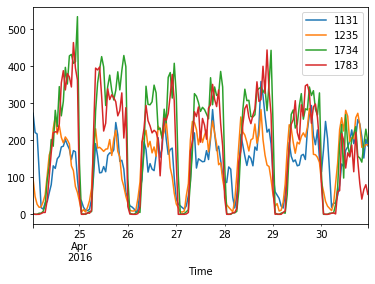

In [19]:
pivoted_dt.loc[(pivoted_dt.index <pd.Timestamp("2016-05-01 00:00:00")) &\
              (pivoted_dt.index >pd.Timestamp("2016-04-24 00:00:00"))][cluster_smr.loc[cluster_smr.labels == 4].square_id.tolist()].plot()

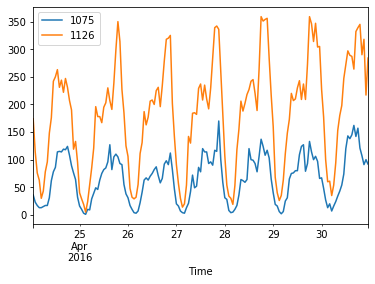

In [20]:
pivoted_dt.loc[(pivoted_dt.index <pd.Timestamp("2016-05-01 00:00:00")) &\
              (pivoted_dt.index >pd.Timestamp("2016-04-24 00:00:00"))][['1075', '1126']].plot()